# A bed occupancy model with SimPy

SimPy is a process-based discrete-event simulation framework based on standard Python.

The purpose of the examples presented here is not to give basic training in Simpy. For that please go to:

https://simpy.readthedocs.io/en/latest/contents.html

The purpose of the examples here are to show how Simpy may be used for healthcare pathway modelling.

We will start with a relatively simple hospital ward bed occupancy model.

Patients arrive at a given average rate, with the time between any two patients sampled from an exponential distribution. Length of stay in the hospital is again sampled from an exponential distribution. We assume here that the hospital ward can expand to cope with peaks in demand, and use the model to look at the expected natural variation in ward bed occupancy.

## Import the packages.

IMPORTANT: Simpy is not in the Anaconda environment. To download, open a command line environment and type: 

pip install simpy

In [20]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt

# For Jupyter Notebook use only:
% matplotlib inline

## Storing variables

We'll store global variables in a class, g. Variables are then referred to as g.var_name. It is not strictly necessary, but is a convenient way of allowing functions to directly change global variables (well, I like doing it this way anyway!).

For those more familiar with object-based programming, you will notice that we just use the class itsled, rather than creating an individual instance of the class.

In [21]:
class g():
    # Global variables
    bed_count=0
    inter_arrival_time=1
    los=10 # length of stay
    sim_duration=500
    audit_time=[]
    audit_beds=[]
    audit_interval=1 # bed occupancy is measured at this interval 

## Generating new arrivals

The new arrival function continuously generated new arrivals.

In [22]:
def new_admission(env,interarrival_time,los):
    i=0
    while True:
        i+=1
        p_los=random.expovariate(1/los) # sample length of stay for patient
        p=patient(env,i,p_los) # generate a patient
        env.process(p) # activate the patient
        next_p=random.expovariate(1/interarrival_time) # sample next arrival time
        # print('Next patient in %f3.2' %next_p)
        yield env.timeout(next_p) # set up next arrival

## Patient pathway

When a new patient arrives, hospital bed occupancy is increased by one. A delay is then triggered for that patient according to their length of stay. At the end of that time-out the patient leaves and bed occupancy is reduced by one.

In [23]:
def patient(env,i,p_los):
    g.bed_count+=1 # adjust global variable for occupied beds
    # print('Patient %d arriving %7.2f, bed count %d' %(i,env.now,g.bed_count))
    yield env.timeout(p_los) # set delay according to length of stay
    g.bed_count-=1
    # print('Patient %d leaving %7.2f, bed count %d' %(i,env.now,g.bed_count))

## Audit of beds

The audit runs at regular time intervals. Each time it runs, it adds to two global lists - one recording the simulated time, and the other the number of beds currently occupied.

In [24]:
def audit_beds(env,delay):
    yield env.timeout(delay)
    while True:
        g.audit_time.append(env.now)
        g.audit_beds.append(g.bed_count)
        yield env.timeout(g.audit_interval)

## Generate audit report

At the end of the simulation run, an audit report is generated to summarise hospital bed occupancy variation. This may be viewed directly, but is used here in the occupancy chart produced.

In [25]:
def build_audit_report():
    audit_report=pd.DataFrame()
    audit_report['Time']=g.audit_time
    audit_report['Occupied_beds']=g.audit_beds
    audit_report['Median_beds']=audit_report['Occupied_beds'].quantile(0.5)
    audit_report['Beds_5_percent']=audit_report['Occupied_beds'].quantile(0.05)
    audit_report['Beds_95_percent']=audit_report['Occupied_beds'].quantile(0.95)
    return audit_report

## Charting occupancy

At then end of the run a chart of bed occupancy is produced.

In [26]:
def chart():
    plt.plot(g.audit_dataframe['Time'],
             g.audit_dataframe['Occupied_beds'],
             color='k',marker='o',linestyle='solid',
             markevery=1,label='Occupied beds')
    
    plt.plot(g.audit_dataframe['Time'],
             g.audit_dataframe['Beds_5_percent'],
             color='0.5',linestyle='dashdot',
             markevery=1,label='5th percentile')
    
    plt.plot(g.audit_dataframe['Time'],
             g.audit_dataframe['Median_beds'],
             color='0.5',linestyle='dashed',
             label='Median')
    
    plt.plot(g.audit_dataframe['Time'],
             g.audit_dataframe['Beds_95_percent'],
             color='0.5',linestyle='dashdot',
             label='95th percentile')
    
    plt.xlabel('Day')
    plt.ylabel('Occupied beds') 
    plt.title('Occupied beds (individual days with 5th, 50th and 95th percentiles)')
    #plt.legend()
    plt.show()

## Main code

The main code sets up the simulation environment, and initialises the first admission and the first audit (these then maintain themselves by triggering the next admission/audit). It then starts the simulation environment and sets the run time. At the end of the run functions to summarise and plot occupancy are called.

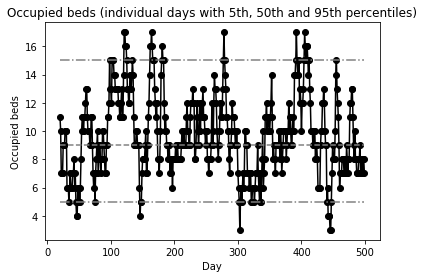

In [27]:
# Initialise environment
env=simpy.Environment()
# Initialise processes (admissions & bed audit)
env.process(new_admission(env,g.inter_arrival_time,g.los))
env.process(audit_beds(env,delay=20))
# Start simulation run
env.run(until=g.sim_duration)
# Build audit table
g.audit_dataframe=build_audit_report()
chart()